# Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import cv2
import os

%matplotlib inline

# Lane Detection Pipeline

This section performs the following operations to detect (and draw) lanes in a frame:

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Histogram peak extraction
6. Sliding window lane search
7. Searching from prior lane bounds (look-ahead filter)
8. Inverse perspective transform


## Basic Test Pipeline

A basic pipeline will be developed to test on a set of test images. This provides core functionality to the entire pipeline, and includes the following:

### Image Pre-Processing
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

### Lane Detection
1. Histogram peak extraction
2. Sliding window lane search

### Visualization
1. Inverse perspective warp

# Helper Functions

In [2]:
def calibrate(images=[], nx=5, ny=5, vis=False, verbose=False):
    '''
    Calculates the camera calibration matrix and distortion coefficients using a sample of chessboard images. Grid size must be specified as the number of non-edge corners on the chessboard image.
    '''
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in the image plane

    # nx Number of grids in x-axis
    # ny Number of grids in y-axis

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    valid_images = 0
    total_images = len(images)

    for image in images:
        img = mpimg.imread(image)
        # Creating a grayscale image for the corner detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        #TODO: Add 8-bit image check, which is necessary if a .png is imported instead of a .jpg
        # Conversion is (gray*255).astype(np.uint8)

        # Finding chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add the object and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            valid_images += 1
            # Visualize the corners
            if vis == True:
                img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                plt.imshow(img)
                plt.show()

    if verbose == True:
        print('{} of the {} calibration images were valid'.format(valid_images, total_images))

    # Calibrate the camera using the object and image points    
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvec, tvec

## 1. Camera Calibration

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')

In [4]:
# Calibrate the camera
ret, mtx, dist, rvec, tvec = calibrate(images, nx=9, ny=6, verbose=True)

17 of the 20 calibration images were valid


## 2. Distortion Correction

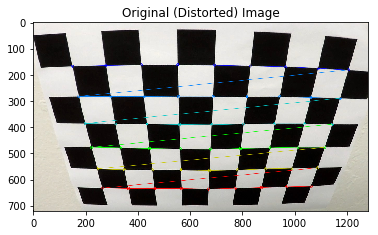

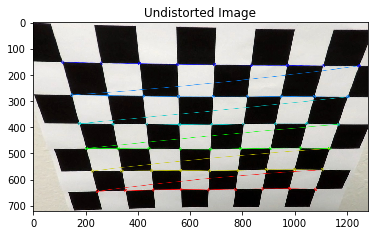

In [5]:
# Testing the calibration
test_img = mpimg.imread('camera_cal/calibration2.jpg')
test_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(test_gray, (9,6), None)
if ret == True:
    test_img = cv2.drawChessboardCorners(test_img, (9,6), corners, ret)
    plt.imshow(test_img)
    plt.title('Original (Distorted) Image')
    plt.show()

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.title('Undistorted Image')
plt.show()

## 3. Color and Gradient Threshold

### Sobel Helper Functions

In [6]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    Returns a binary image based on the threshold of direction of a Sobel operation.
    '''
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Creating a thresholded sobel
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Creating a binary mask
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Returns a binary image based on the magnitude of a sobel operation.
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Magnitude of the Sobel
    abs_sobel = np.sqrt(np.add(np.power(sobelx, 2), np.power(sobely, 2)))

    # Creating a thresholded sobel
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Creating binary mask
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Returns a binary image based on the threshold of the gradient of a Sobel operation.
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Computing Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Computing sobel gradients
    grad = np.arctan2(abs_sobely, abs_sobelx)
    
    # Creating binary mask based on thresholds
    dir_binary = np.zeros_like(grad)
    dir_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1

    return dir_binary

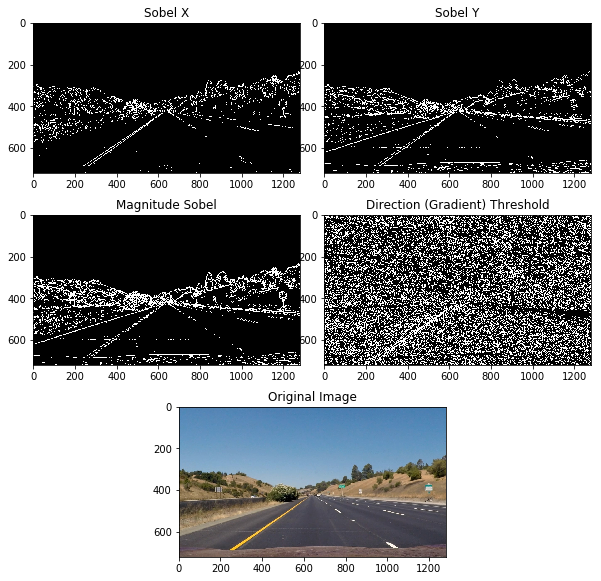

In [7]:
test_img = mpimg.imread('test_images/straight_lines1.jpg')

# Testing Sobel Operations
sobel_binx = abs_sobel_thresh(test_img, orient='x', thresh=(20,100))
sobel_biny = abs_sobel_thresh(test_img, orient='y', thresh=(20,100))
sobel_mag = mag_thresh(test_img, mag_thresh=(20,100))
sobel_dir = dir_threshold(test_img, thresh=(0.53, 1.13))

# Plotting Sobel Operation
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])
ax2 = plt.subplot(gs[1, :2], )
ax3 = plt.subplot(gs[1, 2:])
ax4 = plt.subplot(gs[2, 1:3])

ax0.set_title('Sobel X')
ax1.set_title('Sobel Y')
ax2.set_title('Magnitude Sobel')
ax3.set_title('Direction (Gradient) Threshold')
ax4.set_title('Original Image')

ax0.imshow(sobel_binx, cmap='gray')
ax1.imshow(sobel_biny, cmap='gray')
ax2.imshow(sobel_mag, cmap='gray')
ax3.imshow(sobel_dir, cmap='gray')
ax4.imshow(test_img);


#### Sobel Note
> The X-direction Sobel operation performs the best, as it captures the most detail in lane lines with the least amount deail captured for the surroundings.

### Color Mask Helper Functions

In [8]:
def color_mask(image, thresh=(0,255)):
    '''
    Returns a binary image with thresholds applied to the saturation channel of the image.
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return color_binary

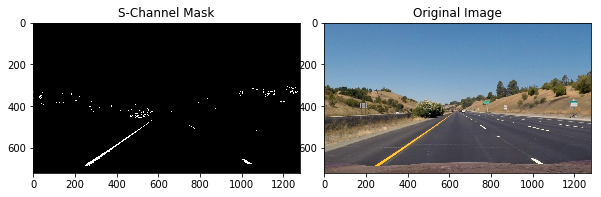

In [9]:
# Plotting Sobel Operation
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])

ax0.set_title('S-Channel Mask')
ax1.set_title('Original Image')

ax0.imshow(color_mask(test_img, thresh=(175,255)), cmap='gray')
ax1.imshow(test_img);

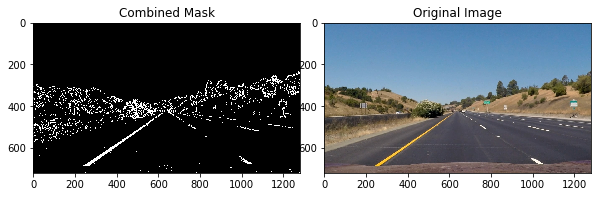

In [10]:
col_mask = color_mask(test_img, thresh=(175,255))
grad_mask = abs_sobel_thresh(test_img, orient='x', thresh=(20,100))

colgrad_mask = np.zeros_like(test_img[:,:,0])
colgrad_mask[(col_mask == 1) | (grad_mask == 1)] = 1

# Plotting Color and Gradient Combined Mask
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(10,10))
ax0 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])

ax0.set_title('Combined Mask')
ax1.set_title('Original Image')

ax0.imshow(colgrad_mask, cmap='gray')
ax1.imshow(test_img);

## 4. Perspective Transform

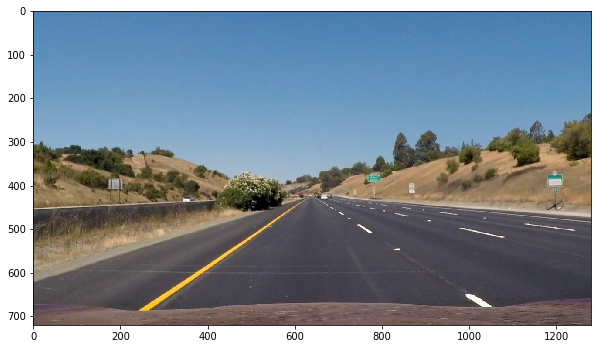

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(test_img)

### Perspective Warp Helper Functions

In [92]:
def warp(image, src=None, dst=None):
    '''
    Perform a perspective warp on an undistorted image, from src points to dst points.
    src and dst are np.float32([[], [], []...])
    '''
    warped = None
    if src is None:
        # Average lane points from source image
        src = np.float32([
            [245, image.shape[0]],
            [600, 450],
            [660, 450],
            [965, image.shape[0]]
        ])

    if dst is None:
        # Perspective Warp which transforms to a straight lane
        dst = np.float32([
            [450, test_img.shape[0]+100],
            [450, 0],
            [800, 0],
            [800, test_img.shape[0]+100]
        ])

    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

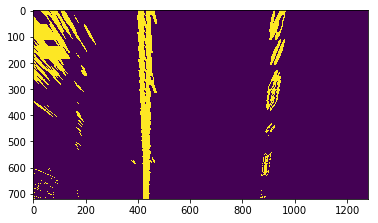

In [97]:

plt.imshow(warp(colgrad_mask));